Tutorial on how to get tweets, clean them and analyze general word frequency and sentiments for a certain hashtag and country. 
Focused on spanish words

# Import packages

In [1]:
from textblob import TextBlob
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns

# Wordcloud
from wordcloud import WordCloud
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Tokenize and prepare text
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

# For plot background
plt.rcParams['axes.facecolor']='white'

In [2]:
# Config display 
pd.set_option('display.max_colwidth', None)


# Authentication credentials 

In [3]:
# Your API credentials
consumerKey = input("consumerKey: ")
consumerSecret = input("consumerSecret: ")
accessToken = input("accessToken: ")
accessTokenSecret = input("accessTokenSecret: ")


auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

# Getting Tweets

In [4]:
# For sentiment and stopwords
nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/natashadiaz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natashadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Import tweets
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))
country = input("Please enter country to focus analysis: ")
places = api.search_geo(query=country, granularity="country")
print(places[0].name)
place_id = places[0].id
tweets = tweepy.Cursor(api.search_tweets, q="(" + keyword + ") AND place:" + place_id).items(noOfTweet)
tweet_list = []
tweet_tags = []
for tweet in tweets:
    tweet_list.append(tweet.text)
    hashtags = tweet.entities['hashtags']
    hashtext = list()
    for j in range(0, len(hashtags)):
        hashtext.append(hashtags[j]['text'])
    tweet_tags.append(hashtext)
tweet_list = pd.DataFrame(tweet_list)
all_tags = [item for sublist in tweet_tags for item in sublist]
print(np.unique(np.array(all_tags)))
tweet_list.head()

Costa Rica
['AcademiadeDanzaUrbana' 'Arenal' 'ArianaArana' 'BCCR' 'Beach'
 'BuenasNoches' 'CR' 'Campeón' 'Caribe' 'CaribeSur' 'CasaSerena'
 'Coldplay' 'Combustibles' 'Copa' 'CostaRica' 'Costarica' 'DepecheMode'
 'DiversidadBiológica' 'Diversion' 'DomingosDeEmpleo' 'Empleo' 'EmpleoCR'
 'Epico' 'Escocia' 'Gasolina' 'GeraldDrummond' 'Gifs' 'Guanacaste'
 'INCOFER' 'Iberoamericano' 'Instagram' 'KrystelBrenes' 'Manzanillo'
 'MarCaribe' 'Marathon' 'MarathonRunner' 'MaratónDeSanJose' 'Matapalo'
 'MeCagoEnRECOPE' 'MediaFire' 'MovimientoSRS' 'NFTCommunity' 'NFTs'
 'Nikon' 'Niña' 'Picapiedra' 'PriscillaChinchilla' 'PuraVida' 'SRSCR'
 'SRSproduccion' 'SanJose' 'SanJosé' 'SiSePuede' 'SoundCloud'
 'StangerThings' 'StreetArt' 'Telegram' 'TheCleanWave' 'Trabajo'
 'TrabajoCR' 'Travel' 'TravelAway' 'TravelingTheWorld' 'Trofeo' 'Turismo'
 'Turrialba' 'Twitter' 'Vacation' 'ViernesDePachucadas' 'View'
 'YoSoyCreador' 'YouTube' 'academia' 'animal' 'anime' 'antesydespues'
 'arqts2010' 'beach' 'beachlover' 'b

,0
0,"Zenit \n\n#zenit \n#zenitlens \n#fujifilm \n#photography \n#fujifilmphotography \n#palmares \n#costarica en Candelaria, Ala… https://t.co/tDM4UwlFYo"
1,"“Acostúmbrate a tener un presupuesto buen definido para alimentos, traslado, recreación… eso es planificación finan… https://t.co/NXVEjj8zn7"
2,"You can't get good sushi in Costa Rica they said. This is Shogun near Flamingo, some of the best nigiri I've had in… https://t.co/yU8QHbyEUm"
3,Hola Costa Rica! Estamos listos si tu estas listo. #CostaRica #SanJose https://t.co/R5fPJzKjr6
4,🌻 \nsolo hace falta dejar de insistir.\n.\n.\n#photography #transgender #trans #transgirl #costarica #venezuela en Cost… https://t.co/CWDKUOTF4Q


In [6]:
tweet_list.loc[0]

0    Zenit \n\n#zenit \n#zenitlens \n#fujifilm \n#photography \n#fujifilmphotography \n#palmares \n#costarica en Candelaria, Ala… https://t.co/tDM4UwlFYo
Name: 0, dtype: object

# Data prep

In [7]:
# Cleaning
tweet_list.drop_duplicates(inplace = True)

In [8]:
# Cleaning Text (RT, Punctuation etc)
# Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]
# Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,"Zenit \n\n#zenit \n#zenitlens \n#fujifilm \n#photography \n#fujifilmphotography \n#palmares \n#costarica en Candelaria, Ala… https://t.co/tDM4UwlFYo",zenit zenit zenitlens fujifilm photography fujifilmphotography palmares costarica en candelaria ala
1,"“Acostúmbrate a tener un presupuesto buen definido para alimentos, traslado, recreación… eso es planificación finan… https://t.co/NXVEjj8zn7",acost mbrate a tener un presupuesto buen definido para alimentos traslado recreaci n eso es planificaci n finan
2,"You can't get good sushi in Costa Rica they said. This is Shogun near Flamingo, some of the best nigiri I've had in… https://t.co/yU8QHbyEUm",you can t get good sushi in costa rica they said this is shogun near flamingo some of the best nigiri i ve had in
3,Hola Costa Rica! Estamos listos si tu estas listo. #CostaRica #SanJose https://t.co/R5fPJzKjr6,hola costa rica estamos listos si tu estas listo costarica sanjose
4,🌻 \nsolo hace falta dejar de insistir.\n.\n.\n#photography #transgender #trans #transgirl #costarica #venezuela en Cost… https://t.co/CWDKUOTF4Q,solo hace falta dejar de insistir photography transgender trans transgirl costarica venezuela en cost
5,"Hace una semana llevé a mami al concierto de @elnodal en #CostaRica no escuchábamos muy bien, pero si que lo disfru… https://t.co/Qfob5hmqgt",hace una semana llev a mami al concierto de en costarica no escuch bamos muy bien pero si que lo disfru
6,#costaricaesencial #costarica https://t.co/Vok1DaPdA9,costaricaesencial costarica
7,The #View from #Arenal Lodge near the Arenal Volcano. #CostaRica #Vacation @ Arenal volcano national park https://t.co/HvBJM3mzF2,the view from arenal lodge near the arenal volcano costarica vacation arenal volcano national park
8,🇨🇷💁🏻‍♀️🥁Super Orgullosos | #Niña tica #KrystelBrenes gana primer lugar en competencia #latina de #mujeres… https://t.co/w8JxprKCqk,super orgullosos ni a tica krystelbrenes gana primer lugar en competencia latina de mujeres
9,"I might have got a bit excited when I found a new clearing in the jungle, I guess the recent storms really shook th… https://t.co/hmiCMz9vX4",i might have got a bit excited when i found a new clearing in the jungle i guess the recent storms really shook th


In [9]:
# Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    #stopwords = set(STOPWORDS) # in english
    stopwords_sp = set(stopwords.words('spanish')) # in spanish
    wc = WordCloud(background_color="white",
    mask = mask,
    max_words=3000,
    stopwords=stopwords_sp,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))


Word Cloud Saved Successfully


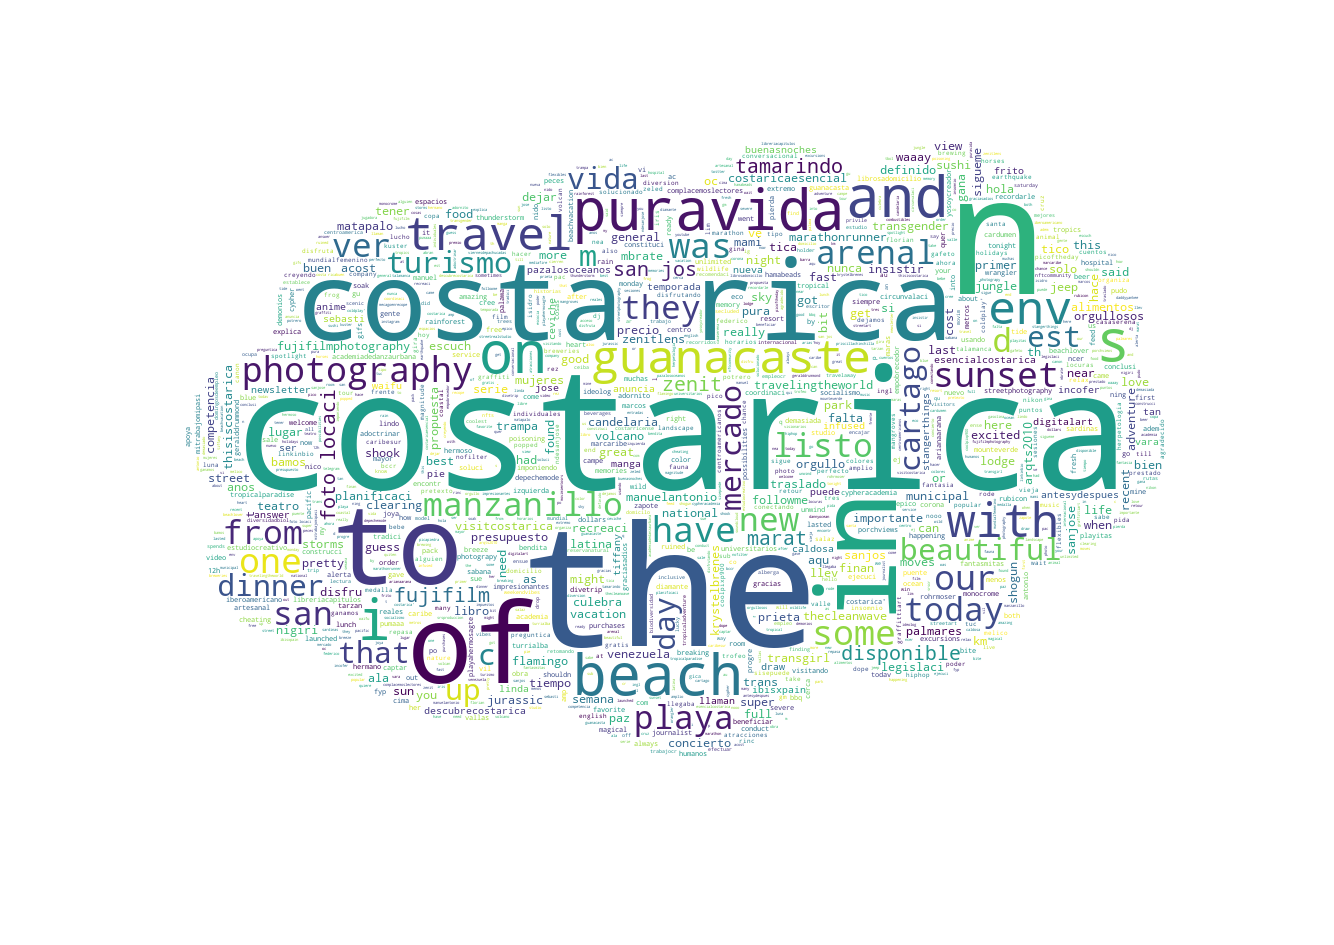

In [10]:
# Creating wordcloud for all tweets
create_wordcloud(tw_list["text"].values)

Text processing and cleaning 

In [11]:
# Tokenization 
regexp = RegexpTokenizer('\w+')

tw_list['text_token']=tw_list['text'].apply(regexp.tokenize)
tw_list.head(3)

,0,text,text_token
0,"Zenit \n\n#zenit \n#zenitlens \n#fujifilm \n#photography \n#fujifilmphotography \n#palmares \n#costarica en Candelaria, Ala… https://t.co/tDM4UwlFYo",zenit zenit zenitlens fujifilm photography fujifilmphotography palmares costarica en candelaria ala,"[zenit, zenit, zenitlens, fujifilm, photography, fujifilmphotography, palmares, costarica, en, candelaria, ala]"
1,"“Acostúmbrate a tener un presupuesto buen definido para alimentos, traslado, recreación… eso es planificación finan… https://t.co/NXVEjj8zn7",acost mbrate a tener un presupuesto buen definido para alimentos traslado recreaci n eso es planificaci n finan,"[acost, mbrate, a, tener, un, presupuesto, buen, definido, para, alimentos, traslado, recreaci, n, eso, es, planificaci, n, finan]"
2,"You can't get good sushi in Costa Rica they said. This is Shogun near Flamingo, some of the best nigiri I've had in… https://t.co/yU8QHbyEUm",you can t get good sushi in costa rica they said this is shogun near flamingo some of the best nigiri i ve had in,"[you, can, t, get, good, sushi, in, costa, rica, they, said, this, is, shogun, near, flamingo, some, of, the, best, nigiri, i, ve, had, in]"


In [12]:
# Stopwords - default ones
stopwords = nltk.corpus.stopwords.words("spanish")

# Extend the list with your own custom stopwords
my_stopwords = ['costarica', 'costa',
 'rica']
stopwords.extend(my_stopwords)

# Remove stopwords
tw_list['text_token'] = tw_list['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
tw_list.head(3)

,0,text,text_token
0,"Zenit \n\n#zenit \n#zenitlens \n#fujifilm \n#photography \n#fujifilmphotography \n#palmares \n#costarica en Candelaria, Ala… https://t.co/tDM4UwlFYo",zenit zenit zenitlens fujifilm photography fujifilmphotography palmares costarica en candelaria ala,"[zenit, zenit, zenitlens, fujifilm, photography, fujifilmphotography, palmares, candelaria, ala]"
1,"“Acostúmbrate a tener un presupuesto buen definido para alimentos, traslado, recreación… eso es planificación finan… https://t.co/NXVEjj8zn7",acost mbrate a tener un presupuesto buen definido para alimentos traslado recreaci n eso es planificaci n finan,"[acost, mbrate, tener, presupuesto, buen, definido, alimentos, traslado, recreaci, n, planificaci, n, finan]"
2,"You can't get good sushi in Costa Rica they said. This is Shogun near Flamingo, some of the best nigiri I've had in… https://t.co/yU8QHbyEUm",you can t get good sushi in costa rica they said this is shogun near flamingo some of the best nigiri i ve had in,"[you, can, t, get, good, sushi, in, they, said, this, is, shogun, near, flamingo, some, of, the, best, nigiri, i, ve, had, in]"


In [13]:
# Remove infrequent words - longer than 5 characters
length = 5
tw_list['text_string'] = tw_list['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>=length]))
tw_list[['text', 'text_token', 'text_string']].head()

,text,text_token,text_string
0,zenit zenit zenitlens fujifilm photography fujifilmphotography palmares costarica en candelaria ala,"[zenit, zenit, zenitlens, fujifilm, photography, fujifilmphotography, palmares, candelaria, ala]",zenit zenit zenitlens fujifilm photography fujifilmphotography palmares candelaria
1,acost mbrate a tener un presupuesto buen definido para alimentos traslado recreaci n eso es planificaci n finan,"[acost, mbrate, tener, presupuesto, buen, definido, alimentos, traslado, recreaci, n, planificaci, n, finan]",acost mbrate tener presupuesto definido alimentos traslado recreaci planificaci finan
2,you can t get good sushi in costa rica they said this is shogun near flamingo some of the best nigiri i ve had in,"[you, can, t, get, good, sushi, in, they, said, this, is, shogun, near, flamingo, some, of, the, best, nigiri, i, ve, had, in]",sushi shogun flamingo nigiri
3,hola costa rica estamos listos si tu estas listo costarica sanjose,"[hola, listos, si, listo, sanjose]",listos listo sanjose
4,solo hace falta dejar de insistir photography transgender trans transgirl costarica venezuela en cost,"[solo, hace, falta, dejar, insistir, photography, transgender, trans, transgirl, venezuela, cost]",falta dejar insistir photography transgender trans transgirl venezuela


In [14]:
# Full list of words concatenated
all_words = ' '.join([word for word in tw_list['text_string']])

# Tokenize them
tokenized_words = nltk.tokenize.word_tokenize(all_words)

# Obtain frequency distribution 
fdist = FreqDist(tokenized_words)
fdist

# Remove infrequent words
freq = 1 # no filter
tw_list['text_string_fdist'] = tw_list['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= freq]))


In [15]:
# Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

tw_list['text_string_lem'] = tw_list['text_string_fdist'].apply(wordnet_lem.lemmatize)

# Check how much were changed (False)
tw_list['is_equal']= (tw_list['text_string_fdist']==tw_list['text_string_lem'])
tw_list.is_equal.value_counts() 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natashadiaz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/natashadiaz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True    99
Name: is_equal, dtype: int64

## Improved wordcloud

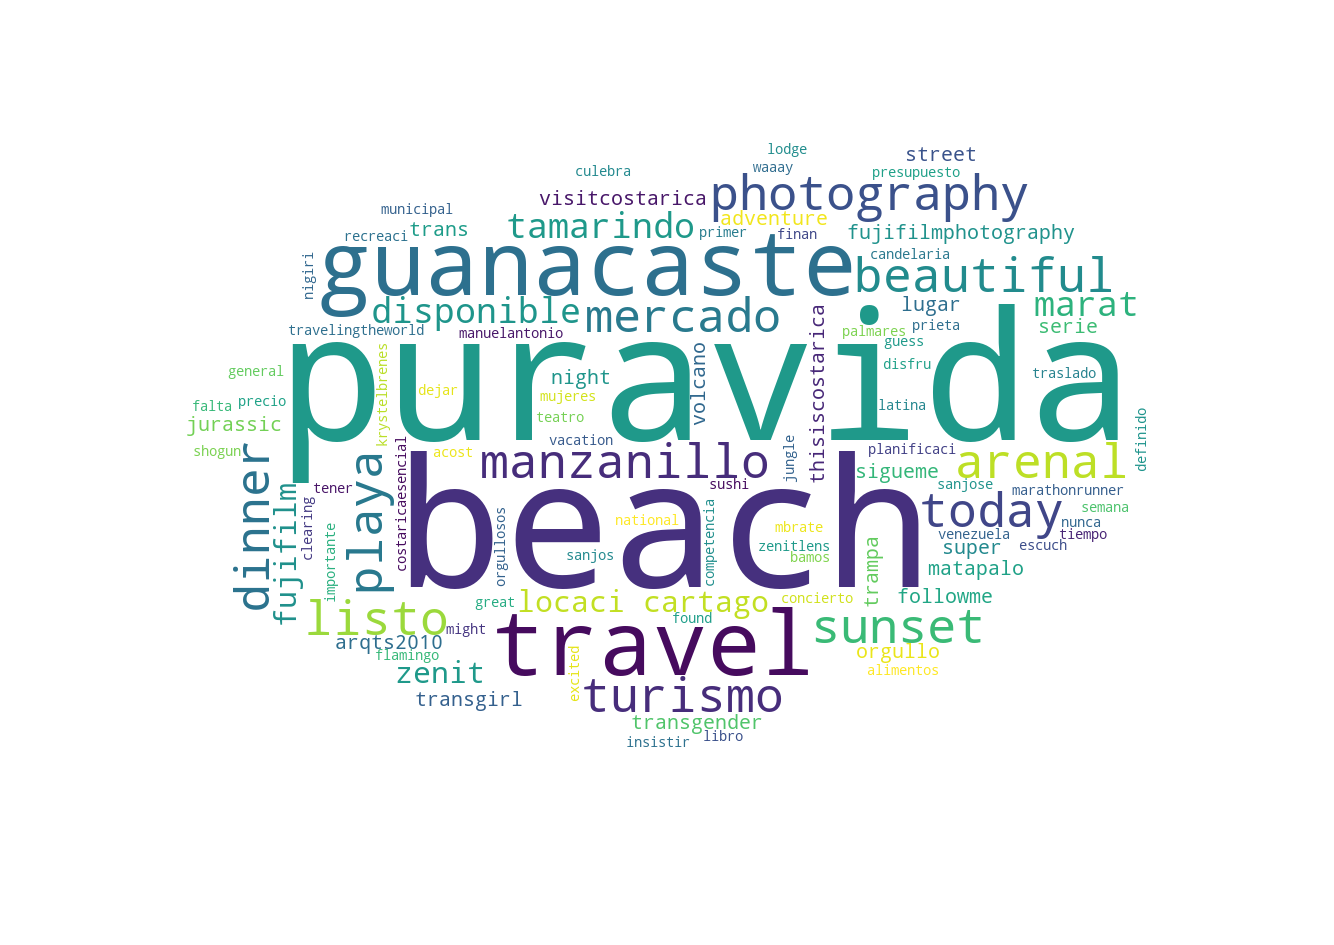

In [16]:
# New wordcloud 
# Text for cloud
all_words_lem = ' '.join([word for word in tw_list['text_string_lem']])
# Cloud
mask = np.array(Image.open("cloud.png"))
wc = WordCloud(background_color="white",
mask = mask,
max_words=100,
repeat=True)
wc.generate(all_words_lem)
wc.to_file("wc.png")
path="wc.png"
display(Image.open(path))


## Bar plot for word frequency

Text(0.5, 1.0, 'Frecuencia de palabras en tweets #NiUnaMenos')

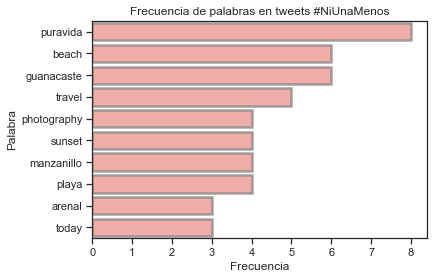

In [17]:
words = nltk.word_tokenize(all_words_lem)
fd = FreqDist(words)
# Only top 10
top_10 = fd.most_common(10)

# Plot
fdist = pd.Series(dict(top_10))
sns.set_theme(style="ticks")
sns.barplot(y=fdist.index, x=fdist.values, color='salmon',
alpha=0.7, linewidth=2.5, edgecolor="gray")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.title("Frecuencia de palabras en tweets #CostaRica")

## Types of sentiments - analysis and plots

In [18]:
# Using pysentimient scores for each tweet in spanish
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")


In [19]:
from tqdm.auto import tqdm
for tweet in tqdm(tw_list['text_string_lem']):
    analyzer.predict(tweet)

  0%|          | 0/99 [00:00<?, ?it/s]

In [20]:
rets = analyzer.predict(tw_list['text_string_lem'])

Parameter 'function'=<function Analyzer._tokenize at 0x7f910b2b75f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/4 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 99
  Batch size = 32


  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
labels = []
for i in rets:
    label = str(i)[22:25]
    labels.append(label)

tw_list["label"] = labels


In [22]:
tw_list.head()

,0,text,text_token,text_string,text_string_fdist,text_string_lem,is_equal,label
0,"Zenit \n\n#zenit \n#zenitlens \n#fujifilm \n#photography \n#fujifilmphotography \n#palmares \n#costarica en Candelaria, Ala… https://t.co/tDM4UwlFYo",zenit zenit zenitlens fujifilm photography fujifilmphotography palmares costarica en candelaria ala,"[zenit, zenit, zenitlens, fujifilm, photography, fujifilmphotography, palmares, candelaria, ala]",zenit zenit zenitlens fujifilm photography fujifilmphotography palmares candelaria,zenit zenit zenitlens fujifilm photography fujifilmphotography palmares candelaria,zenit zenit zenitlens fujifilm photography fujifilmphotography palmares candelaria,True,NEU
1,"“Acostúmbrate a tener un presupuesto buen definido para alimentos, traslado, recreación… eso es planificación finan… https://t.co/NXVEjj8zn7",acost mbrate a tener un presupuesto buen definido para alimentos traslado recreaci n eso es planificaci n finan,"[acost, mbrate, tener, presupuesto, buen, definido, alimentos, traslado, recreaci, n, planificaci, n, finan]",acost mbrate tener presupuesto definido alimentos traslado recreaci planificaci finan,acost mbrate tener presupuesto definido alimentos traslado recreaci planificaci finan,acost mbrate tener presupuesto definido alimentos traslado recreaci planificaci finan,True,NEU
2,"You can't get good sushi in Costa Rica they said. This is Shogun near Flamingo, some of the best nigiri I've had in… https://t.co/yU8QHbyEUm",you can t get good sushi in costa rica they said this is shogun near flamingo some of the best nigiri i ve had in,"[you, can, t, get, good, sushi, in, they, said, this, is, shogun, near, flamingo, some, of, the, best, nigiri, i, ve, had, in]",sushi shogun flamingo nigiri,sushi shogun flamingo nigiri,sushi shogun flamingo nigiri,True,NEU
3,Hola Costa Rica! Estamos listos si tu estas listo. #CostaRica #SanJose https://t.co/R5fPJzKjr6,hola costa rica estamos listos si tu estas listo costarica sanjose,"[hola, listos, si, listo, sanjose]",listos listo sanjose,listos listo sanjose,listos listo sanjose,True,NEU
4,🌻 \nsolo hace falta dejar de insistir.\n.\n.\n#photography #transgender #trans #transgirl #costarica #venezuela en Cost… https://t.co/CWDKUOTF4Q,solo hace falta dejar de insistir photography transgender trans transgirl costarica venezuela en cost,"[solo, hace, falta, dejar, insistir, photography, transgender, trans, transgirl, venezuela, cost]",falta dejar insistir photography transgender trans transgirl venezuela,falta dejar insistir photography transgender trans transgirl venezuela,falta dejar insistir photography transgender trans transgirl venezuela,True,NEG


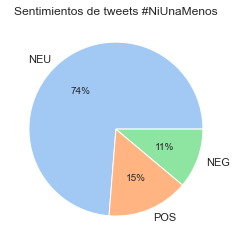

In [23]:
sentiments_df = tw_list.label.value_counts().reset_index()
colors = sns.color_palette('pastel')[0:5]
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(sentiments_df["label"], labels = sentiments_df["index"], colors = colors, autopct='%.0f%%' )
plt.title("Sentimientos de tweets #CostaRica")
plt.show()

This tutorial is inspired by other sources: 
- https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d 
- https://github.com/pysentimiento/pysentimiento